### Imports and Configurations

In [1]:
# Imports
import pandas as pd
import numpy as np
import xgboost as xgb
import optuna
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold, cross_val_score

from sklearn.metrics import (
    accuracy_score, 
    confusion_matrix, 
    classification_report, 
    roc_auc_score, 
    roc_curve,
    precision_recall_curve,
    auc
)
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from scipy.stats import uniform, randint

# Configurations
%matplotlib inline
sns.set(style="whitegrid")
warnings.filterwarnings('ignore') 

print("Libraries imported successfully.")

/Users/sleepdeprived/miniforge3/envs/LLM/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Libraries imported successfully.


### Loading the Data

In [2]:
input_filename = 'cleaned_student_data.csv' 

df_model = pd.read_csv(input_filename)
print(f"\nLoaded data from '{input_filename}'. Shape: {df_model.shape}")

# Quick verification:
print("\nVerifying column types:\n")
print(df_model.info())

# Checking if 'Depression' column exists
if 'Depression' not in df_model.columns:
    raise ValueError("Target column 'Depression' not found in the loaded data.")


Loaded data from 'cleaned_student_data.csv'. Shape: (27851, 91)

Verifying column types:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27851 entries, 0 to 27850
Data columns (total 91 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   Age                                        27851 non-null  float64
 1   Academic Pressure                          27851 non-null  float64
 2   CGPA                                       27851 non-null  float64
 3   Study Satisfaction                         27851 non-null  float64
 4   Suicidal_Thoughts                          27851 non-null  int64  
 5   Work/Study Hours                           27851 non-null  float64
 6   Financial Stress                           27851 non-null  float64
 7   Family History of Mental Illness           27851 non-null  int64  
 8   Depression                                 27851 non-null  int64  
 9   Sle

### Separating Features (X) and Target (y)

In [3]:
target_column = 'Depression'
y = df_model[target_column]
X = df_model.drop(columns=[target_column])

print(f"\nFeatures (X) shape: {X.shape}")
print(f"Target (y) shape: {y.shape}")

print("\nFeature columns used for training:\n")
print(list(X.columns))



Features (X) shape: (27851, 90)
Target (y) shape: (27851,)

Feature columns used for training:

['Age', 'Academic Pressure', 'CGPA', 'Study Satisfaction', 'Suicidal_Thoughts', 'Work/Study Hours', 'Financial Stress', 'Family History of Mental Illness', 'Sleep_Ordinal', 'Total_Stress', 'Gender_Male', 'City_Ahmedabad', 'City_Bangalore', 'City_Bhopal', 'City_Chennai', 'City_Delhi', 'City_Faridabad', 'City_Ghaziabad', 'City_Hyderabad', 'City_Indore', 'City_Jaipur', 'City_Kalyan', 'City_Kanpur', 'City_Kolkata', 'City_Lucknow', 'City_Ludhiana', 'City_Meerut', 'City_Mumbai', 'City_Nagpur', 'City_Nashik', 'City_Patna', 'City_Pune', 'City_Rajkot', 'City_Srinagar', 'City_Surat', 'City_Thane', 'City_Vadodara', 'City_Varanasi', 'City_Vasai-Virar', 'City_Visakhapatnam', 'Dietary Habits_Moderate', 'Dietary Habits_Others', 'Dietary Habits_Unhealthy', 'Degree_B.Com', 'Degree_B.Ed', 'Degree_B.Pharm', 'Degree_B.Tech', 'Degree_BA', 'Degree_BBA', 'Degree_BCA', 'Degree_BE', 'Degree_BHM', 'Degree_BSc', 'Deg

### Checking Class Balance

In [4]:
print("\nTarget Variable Distribution\n")
class_counts = y.value_counts(normalize=True) * 100
print(class_counts)

# Calculating scale_pos_weight for potential use if classes are imbalanced

count_neg = y.value_counts()[0]
count_pos = y.value_counts()[1]

# Handle potential division by zero 
scale_pos_weight_value = 1 
if count_pos > 0:
    scale_pos_weight_value = count_neg / count_pos
print(f"\nCalculated scale_pos_weight: {scale_pos_weight_value:.2f}")



Target Variable Distribution

Depression
1    58.575994
0    41.424006
Name: proportion, dtype: float64

Calculated scale_pos_weight: 0.71


### Splitting Data into Training and Testing Sets

In [5]:
# Using stratify=y to maintain class proportions in train/test splits

test_set_size = 0.2
random_seed = 42   

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=test_set_size, 
    random_state=random_seed, 
    stratify=y  
)

print(f"Training set shape: X_train={X_train.shape}, y_train={y_train.shape}")
print(f"Testing set shape: X_test={X_test.shape}, y_test={y_test.shape}")
print(f"\nTraining set target distribution:\n{y_train.value_counts(normalize=True) * 100}")
print(f"\nTesting set target distribution:\n{y_test.value_counts(normalize=True) * 100}")

Training set shape: X_train=(22280, 90), y_train=(22280,)
Testing set shape: X_test=(5571, 90), y_test=(5571,)

Training set target distribution:
Depression
1    58.577199
0    41.422801
Name: proportion, dtype: float64

Testing set target distribution:
Depression
1    58.571172
0    41.428828
Name: proportion, dtype: float64


### Initialize and Train XGBoost Model

In [6]:
def objective(trial):
    """Optuna objective function to minimize/maximize."""
    
    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'auc',  
        'booster': 'gbtree',
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000, step=50), # Explore # of trees
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True), # Explore learning rate on log scale
        'max_depth': trial.suggest_int('max_depth', 3, 10), # Explore tree depth
        'subsample': trial.suggest_float('subsample', 0.6, 1.0, step=0.05), # Explore subsample ratio
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0, step=0.05), # Explore feature sampling
        'gamma': trial.suggest_float('gamma', 0.0, 0.5, step=0.05), # Explore gamma
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10), # Explore min child weight
        'lambda': trial.suggest_float('lambda', 1e-3, 1.0, log=True), # L2 regularization
        'alpha': trial.suggest_float('alpha', 1e-3, 1.0, log=True),   # L1 regularization
        'random_state': 42, 
    }
    
    model = xgb.XGBClassifier(**params)
    
    n_splits_cv = 5
    cv_strategy = StratifiedKFold(n_splits=n_splits_cv, shuffle=True, random_state=42)
    
    # Performing cross-validation and get the average score
    # Using roc_auc as the scoring metric for optimization
    
    score = cross_val_score(model, X_train, y_train, scoring='roc_auc', cv=cv_strategy, n_jobs=-1)
    
    return score.mean()

In [7]:
# Create and Run the Optuna Study

n_trials = 50  # Number of optimization trials to run.
study_name = 'xgboost-hyperopt' 

print(f"\nStarting Optuna Optimization ({n_trials} trials, optimizing ROC AUC)\n")

study = optuna.create_study(direction="maximize", study_name=study_name)
study.optimize(objective, n_trials=n_trials, timeout=600)
print("\nOptuna Optimization Complete\n")


# Get Best Results from Optuna 
print(f"\nNumber of finished trials: {len(study.trials)}")
print(f"Best trial number: {study.best_trial.number}")
print(f"Best ROC AUC (CV on Train Set): {study.best_value:.4f}")

print("\nBest Parameters found:\n")
best_params = study.best_params
print(best_params)

[I 2025-05-05 10:52:45,772] A new study created in memory with name: xgboost-hyperopt



Starting Optuna Optimization (50 trials, optimizing ROC AUC)



[I 2025-05-05 10:52:48,241] Trial 0 finished with value: 0.9148968727746185 and parameters: {'n_estimators': 950, 'learning_rate': 0.05790924934587465, 'max_depth': 4, 'subsample': 0.75, 'colsample_bytree': 0.85, 'gamma': 0.2, 'min_child_weight': 3, 'lambda': 0.013801732844628378, 'alpha': 0.004118105292302559}. Best is trial 0 with value: 0.9148968727746185.
[I 2025-05-05 10:52:50,670] Trial 1 finished with value: 0.9199443778686683 and parameters: {'n_estimators': 900, 'learning_rate': 0.018694087365244826, 'max_depth': 5, 'subsample': 0.6, 'colsample_bytree': 0.85, 'gamma': 0.2, 'min_child_weight': 7, 'lambda': 0.020714309557520738, 'alpha': 0.0037042090450970008}. Best is trial 1 with value: 0.9199443778686683.
[I 2025-05-05 10:52:52,156] Trial 2 finished with value: 0.9212426017153088 and parameters: {'n_estimators': 350, 'learning_rate': 0.028805118541566813, 'max_depth': 4, 'subsample': 0.75, 'colsample_bytree': 0.65, 'gamma': 0.35000000000000003, 'min_child_weight': 6, 'lambda'


Optuna Optimization Complete


Number of finished trials: 50
Best trial number: 31
Best ROC AUC (CV on Train Set): 0.9215

Best Parameters found:

{'n_estimators': 150, 'learning_rate': 0.076019825096555, 'max_depth': 3, 'subsample': 0.95, 'colsample_bytree': 0.7, 'gamma': 0.5, 'min_child_weight': 9, 'lambda': 0.012889590897157558, 'alpha': 0.9733982351408424}


In [8]:
# Train Final Model with Best Parameters
print("\nTraining Final Model with Best Parameters on Full Training Set")

# Add back fixed parameters that weren't tuned
final_params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss', 
    'booster': 'gbtree',
    'random_state': 42,
}
final_params.update(best_params) # Combine fixed and tuned parameters

best_xgb_model_optuna = xgb.XGBClassifier(**final_params)
best_xgb_model_optuna.fit(X_train, y_train)

print("Final model trained.")


Training Final Model with Best Parameters on Full Training Set
Final model trained.


### Make Predictions

In [9]:
y_pred_train = best_xgb_model_optuna.predict(X_train)
y_pred_test = best_xgb_model_optuna.predict(X_test)
y_pred_proba_train = best_xgb_model_optuna.predict_proba(X_train)[:, 1] 
y_pred_proba_test = best_xgb_model_optuna.predict_proba(X_test)[:, 1] 

print("Predictions made on training and testing sets.")

Predictions made on training and testing sets.


In [10]:
threshold = 0.4

# Apply Threshold 

y_pred_train = (y_pred_proba_train >= threshold).astype(int)
y_pred_test = (y_pred_proba_test >= threshold).astype(int)

### Evaluate Model Performance

In [11]:
# Training Set Performance 

print("\nTraining Set Performance\n")
print(f"Accuracy: {accuracy_score(y_train, y_pred_train):.4f}")
print("Confusion Matrix:\n")
print(confusion_matrix(y_train, y_pred_train))
print("\nClassification Report:")
print(classification_report(y_train, y_pred_train))


Training Set Performance

Accuracy: 0.8513
Confusion Matrix:

[[ 6861  2368]
 [  946 12105]]

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.74      0.81      9229
           1       0.84      0.93      0.88     13051

    accuracy                           0.85     22280
   macro avg       0.86      0.84      0.84     22280
weighted avg       0.85      0.85      0.85     22280




Testing Set Performance

Accuracy: 0.8446


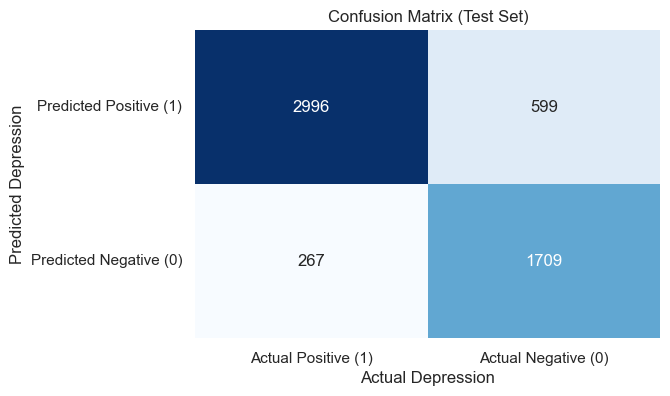


Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.74      0.80      2308
           1       0.83      0.92      0.87      3263

    accuracy                           0.84      5571
   macro avg       0.85      0.83      0.84      5571
weighted avg       0.85      0.84      0.84      5571



In [12]:
#Testing Set Performance

print("\nTesting Set Performance\n")
accuracy_test = accuracy_score(y_test, y_pred_test)
print(f"Accuracy: {accuracy_test:.4f}")

# Plot Confusion Matrix
cm_test = confusion_matrix(y_test, y_pred_test) 

tn, fp, fn, tp = cm_test.ravel()

display_matrix_final = np.array([[tp, fp],
                                 [fn, tn]])

x_labels_final = ["Actual Positive (1)", "Actual Negative (0)"]
y_labels_final = ["Predicted Positive (1)", "Predicted Negative (0)"]

plt.figure(figsize=(6, 4))
sns.heatmap(display_matrix_final,
            annot=True,                
            fmt='d',                   
            cmap='Blues',              
            cbar=False,                
            xticklabels=x_labels_final, 
            yticklabels=y_labels_final) 

plt.xlabel("Actual Depression") 
plt.ylabel("Predicted Depression") 
plt.title("Confusion Matrix (Test Set)") 
plt.yticks(rotation=0)
plt.show()

print("\nClassification Report:")
print(classification_report(y_test, y_pred_test))

In [13]:
# ROC AUC Score 
roc_auc = roc_auc_score(y_test, y_pred_proba_test)
print(f"\nROC AUC Score (Test Set): {roc_auc:.4f}")


ROC AUC Score (Test Set): 0.9220


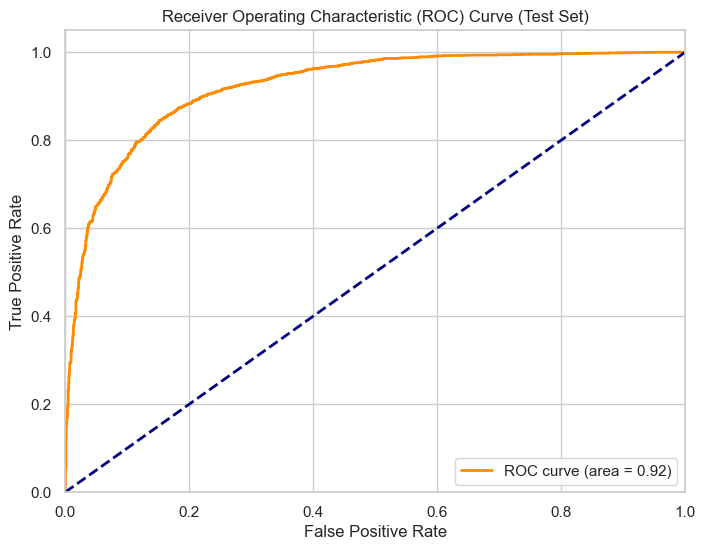

In [14]:
# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_test)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve (Test Set)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

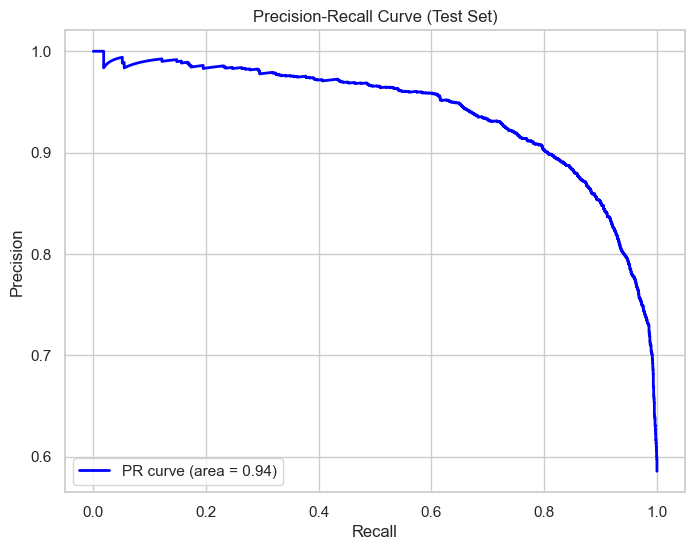

In [15]:
# Plot Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba_test)
pr_auc = auc(recall, precision)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2, label=f'PR curve (area = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (Test Set)')
plt.legend(loc="lower left")
plt.grid(True)
plt.show()

### Feature Importance


-Feature Importance
Top 20 Feature Importances:
                             feature  importance
4                  Suicidal_Thoughts    0.369354
9                       Total_Stress    0.103921
6                   Financial Stress    0.099580
1                  Academic Pressure    0.098058
0                                Age    0.026380
42          Dietary Habits_Unhealthy    0.026120
71                   Age_Group_31-39    0.025488
83        Degree_Field_General/Other    0.024694
5                   Work/Study Hours    0.022148
3                 Study Satisfaction    0.017496
40           Dietary Habits_Moderate    0.014007
8                      Sleep_Ordinal    0.011352
7   Family History of Mental Illness    0.007453
60                         Degree_MA    0.005641
72                    Region_Eastern    0.005537
63                        Degree_MCA    0.005503
76             Degree_Level_Class 12    0.005428
53                   Degree_Class 12    0.005300
20                  

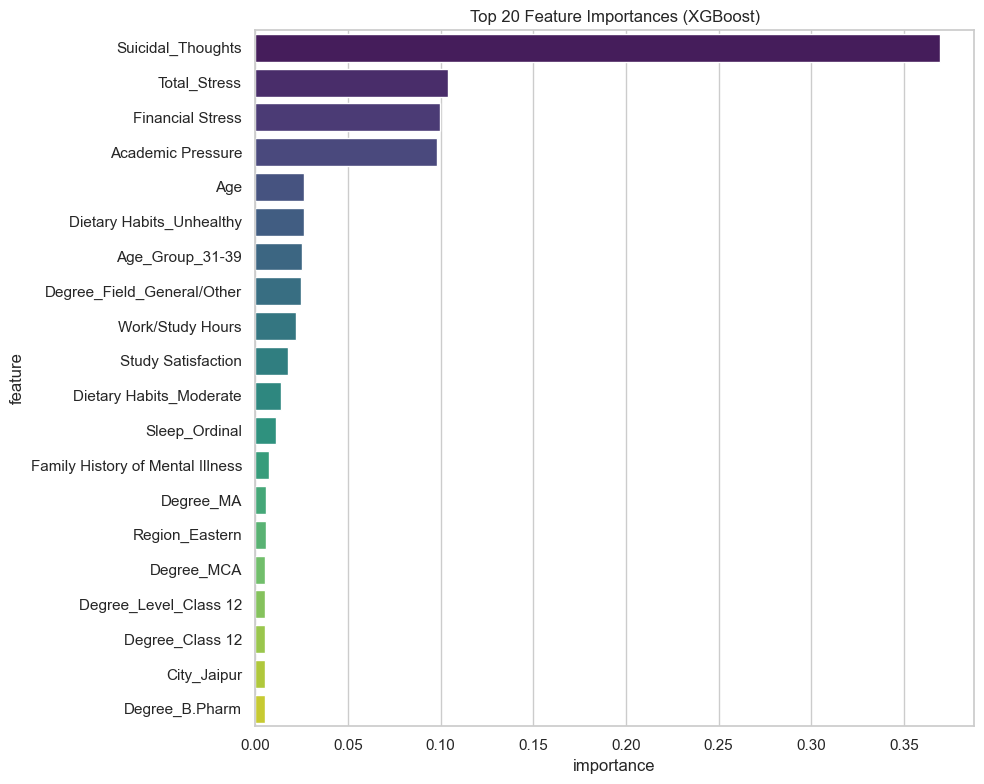

In [16]:
print("\n-Feature Importance")

if hasattr(best_xgb_model_optuna, 'feature_importances_'):
    feature_importances = pd.DataFrame({
        'feature': X.columns,
        'importance': best_xgb_model_optuna.feature_importances_
    }).sort_values('importance', ascending=False)

    print("Top 20 Feature Importances:")
    print(feature_importances.head(20))

    # Plot top N feature importances
    plt.figure(figsize=(10, 8))
    sns.barplot(x='importance', y='feature', data=feature_importances.head(20), palette='viridis')
    plt.title('Top 20 Feature Importances (XGBoost)')
    plt.tight_layout()
    plt.show()
else:
    print("Could not retrieve feature importances from the model.")
